# Table Of Contents

1. [Data Gathering](#gather)

    1.1 [Get Twitter archive from csv file](#archive)
    
    1.2 [Get image predictions by downloading tsv file from url](#predictions)
    
    1.3 [Get additional attributes by querying Twitter API](#api)
    
    
2. [Data Assessment](#assess)

    2.1 [Quality Issues](#quality)
    
    2.2 [Tidiness Issues](#tidiness) 
    
    
3. [Data Cleaning](#clean)

    3.1 [Clean Quality Issues](#clean_quality)
    
    3.2 [Clean Tidiness Issues](#clean_tidiness)
    
    3.3 [Store clean data](#store)
    
    
4. [Data Visualization](#visual)
    

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import json
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

<a id='gather' > </a>
# Data Gathering


<a id='archive'> </a>
### 1- Get Twitter archive from csv file

In [2]:
archive_df = pd.read_csv("twitter-archive-enhanced.csv")
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


<a id='predictions'> </a>
### 2- Get image predictions by downloading tsv file from url


In [3]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(url)
file_name = "image_predictions.tsv"
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(r.content)
image_predictions_df = pd.read_csv(file_name, sep='\t')
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='api'> </a>
### 3- Get additional attributes by querying Twitter API

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

2356

In [5]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552


KeyboardInterrupt: 

In [6]:
# Construct df_api from data retreived from twitter api
df_list = []
with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet['tweet_id'] = tweet['id']
        desired_columns = ['tweet_id', 'retweet_count', 'favorite_count']
        tweet_obj = dict([(key, tweet[key]) for key in desired_columns])
        df_list.append(tweet_obj)
api_df = pd.DataFrame(df_list)
api_df.head()


,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


<a id='assess'> </a>
## Data Assessment

In [7]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
print(archive_df['doggo'].value_counts())
print(archive_df['floofer'].value_counts())
print(archive_df['pupper'].value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64


In [9]:
print(archive_df['rating_numerator'].describe())
print(archive_df['rating_denominator'].describe())

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64
count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64


In [10]:
print(archive_df[archive_df['rating_numerator'] > 100][['rating_numerator', 'rating_denominator']])
ids = archive_df[archive_df['rating_numerator'] > 100]['tweet_id']
image_predictions_df[image_predictions_df['tweet_id'].isin(ids.tolist())]

      rating_numerator  rating_denominator
188                420                  10
189                666                  10
290                182                  10
313                960                   0
902                165                 150
979               1776                  10
1120               204                 170
1634               143                 130
1635               121                 110
1779               144                 120
2074               420                  10


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
277,670842764863651840,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,1,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False
560,677716515794329600,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,1,teddy,0.662908,False,crib,0.031891,False,chow,0.025438,True
692,684222868335505415,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg,1,soft-coated_wheaten_terrier,0.791182,True,cocker_spaniel,0.072444,True,teddy,0.071486,False
693,684225744407494656,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,2,golden_retriever,0.203249,True,Samoyed,0.067958,True,Great_Pyrenees,0.065327,True
1148,731156023742988288,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,1,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False
1270,749981277374128128,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False
1338,758467244762497024,https://pbs.twimg.com/ext_tw_video_thumb/75846...,1,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True


In [11]:
archive_df[archive_df['rating_denominator'] == 0] ## this tweet has no image so it will be removed anyway

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [12]:
tweet = archive_df[archive_df['rating_numerator'] == 1776]
tweet.expanded_urls

979    https://twitter.com/dog_rates/status/749981277...
Name: expanded_urls, dtype: object

In [13]:
tweet = archive_df[archive_df['rating_denominator'] == 170]
tweet.expanded_urls #there are actually 17 dogs in the image

1120    https://twitter.com/dog_rates/status/731156023...
Name: expanded_urls, dtype: object

In [14]:
archive_df[archive_df['expanded_urls']=='None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [15]:
tweets_with_short_names = archive_df[archive_df['name'].astype('str').str.len() < 3]
tweets_with_short_names['name'].value_counts()

a     55
Bo     9
an     7
Jo     1
Al     1
JD     1
by     1
my     1
O      1
Ed     1
Mo     1
Name: name, dtype: int64

In [16]:
tweets_with_short_names['text']

56      Here is a pupper approaching maximum borkdrive...
393     This is Mo. No one will push him around in the...
446     RT @dog_rates: This is Bo. He was a very good ...
449     This is Bo. He was a very good First Doggo. 14...
553     This is Bo. He's going to make me cry. 13/10 p...
                              ...                        
2349    This is an odd dog. Hard on the outside but lo...
2350    This is a truly beautiful English Wilson Staff...
2352    This is a purebred Piers Morgan. Loves to Netf...
2353    Here is a very happy pup. Big fan of well-main...
2354    This is a western brown Mitsubishi terrier. Up...
Name: text, Length: 79, dtype: object

In [17]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
image_predictions_df.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [19]:
print(image_predictions_df.p1.value_counts())
print(image_predictions_df.p1_dog.value_counts())
print(image_predictions_df.p1_conf.describe())
print(image_predictions_df.p2_conf.describe())
print(image_predictions_df.p3_conf.describe())

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
fountain                1
rotisserie              1
cheetah                 1
four-poster             1
tailed_frog             1
Name: p1, Length: 378, dtype: int64
True     1532
False     543
Name: p1_dog, dtype: int64
count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64
count    2.075000e+03
mean     1.345886e-01
std      1.006657e-01
min      1.011300e-08
25%      5.388625e-02
50%      1.181810e-01
75%      1.955655e-01
max      4.880140e-01
Name: p2_conf, dtype: float64
count    2.075000e+03
mean     6.032417e-02
std      5.090593e-02
min      1.740170e-10
25%      1.622240e-02
50%      4.944380e-02
75%      9.180755e-02
max      2.734190e-01
Name: p3_conf, dtype: float64


In [20]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


<a id='quality'> </a>
### Quality Issues
a) `archive_df`
- Missing images for some tweets
- 181 retweets and 78 replies need to be removed (to analyze original tweets only)
- Some records have wrong ratings: 
    - Some tweets with images of packs of dogs have wrong denomirator part (140/10 instead of 140/100 for 10 dogs)
    - Wrong extraction of the rating from the tweet text (a dog smiles 24/7 days)
    - Extreme ratings: 1776/10 for a dog dressed in American flag (1776 is the year of Declaration of Independence of USA)
- Representing null values as string 'None' in the last 4 columns (name, oggo, floofer, pupper, puppo)
- Timestamp should have datetime data type
- Wrong name values (a, an, o, by, my, ..): extracted wrong or names don't exist in the text

b) `image_predictions_df`
- Missing tweets 2075 entries as opposed to 2356 entries in archive_df (tweets with no images should be removed) 
- Column names are non-descriptive (p1_dog, p2,..)
- Inconsistency in using capital letters in columns (p1,p2,p3)

c) `api_df`
- Missing tweets 2354 entries as opposed to 2356 entries in archive_df

<a id='tidiness'> </a>
### Tidiness Issues
a) `archive_df`
- Column headers doggo, floofer, pupper, puppo are values, not variable names

b) `api_df`
-  It is not a separate observational unit (Should be merged with archive table)

<a id='clean'> </a>
## Data Cleaning

In [21]:
archive_df_clean = archive_df.copy()
image_predictions_df_clean = image_predictions_df.copy()
api_df_clean = api_df.copy()

<a id='clean_quality'> </a>
### Clean Quality Issues

#### 181 retweets and 78 replies in `archive_df` need to be removed (to analyze original tweets only)

##### Define
- Remove records that are not original tweets

##### Code

In [22]:
# Select only original tweets
archive_df_clean = archive_df_clean[archive_df_clean.retweeted_status_id.isnull() & archive_df_clean.in_reply_to_status_id.isnull()]

##### Test

In [23]:
print(archive_df_clean.shape[0])
print(2356 - (181 + 78))
print(archive_df_clean.retweeted_status_id.value_counts())
print(archive_df_clean.in_reply_to_status_id.value_counts())

2097
2097
Series([], Name: retweeted_status_id, dtype: int64)
Series([], Name: in_reply_to_status_id, dtype: int64)


In [24]:
# Delete unnecessary columns
archive_df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace = True)
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### Missing images in `archive_df`

##### Define 
Remove archive_df records that do not have images in image_predictions_df

##### Code

In [25]:
# Get tweet_ids with imaegs in image_predictions_df
print(image_predictions_df_clean.shape[0])
ids_with_images = list(image_predictions_df_clean.tweet_id.unique())
len(ids_with_images)

2075


2075

In [26]:
# Check how many tweets in the archive_df have images in image_predictions_df
archive_df_clean.tweet_id.isin(ids_with_images).sum()

1971

In [27]:
# Remove tweets with no images
archive_df_clean = archive_df_clean[archive_df_clean.tweet_id.isin(ids_with_images)]

##### Test

In [28]:
# Check the archive_df size
print(archive_df_clean.shape[0])

# Check that there is not existin tweets that don't have images
print((~archive_df_clean.tweet_id.isin(ids_with_images)).sum())

1971
0


#### Inacurate Ratings issue

##### Define
one-off occurrences
- Check if multiple dogs: get average
- If text has no rating: remove or exclude from analysis
- Extract the right rating from text if exists (consider percentage)
- Drop 2 Outliers: 1776/10 is an outlier and 420/10 is not a dog photo

In [29]:
# Examine different reasons of inacurate ratings
print(archive_df_clean[archive_df_clean['rating_numerator'] > 20][['rating_numerator', 'rating_denominator', 'tweet_id']])

      rating_numerator  rating_denominator            tweet_id
433                 84                  70  820690176645140481
516                 24                   7  810984652412424192
695                 75                  10  786709082849828864
763                 27                  10  778027034220126208
902                165                 150  758467244762497024
979               1776                  10  749981277374128128
1120               204                 170  731156023742988288
1202                50                  50  716439118184652801
1228                99                  90  713900603437621249
1254                80                  80  710658690886586372
1274                45                  50  709198395643068416
1351                60                  50  704054845121142784
1433                44                  40  697463031882764288
1635               121                 110  684222868335505415
1712                26                  10  68049472664

In [30]:
# Extract numerator from text and consider the float numbers
num_p = re.compile('(\d+\.?\d?\d?)\/(\d{1,3})')
archive_df_clean['rating_numerator'] = archive_df_clean.text.str.extract('(\d+\.?\d?\d?)\/\d{1,3}', expand = False).astype('float')

In [31]:
print(archive_df_clean[(archive_df_clean.rating_denominator > 10) & (archive_df_clean.rating_numerator < 10)][['rating_numerator', 'rating_denominator', 'tweet_id']])

      rating_numerator  rating_denominator            tweet_id
1068               9.0                  11  740373189193256964
1165               4.0                  20  722974582966214656
1662               7.0                  11  682962037429899265


In [32]:
# Drop outliers and do manual cleaning
archive_df_clean = archive_df_clean.drop([2074,979,516]) 
archive_df_clean.at[1068,'rating_numerator']= 14
archive_df_clean.at[1068,'rating_denominator']= 10
archive_df_clean.at[1165,'rating_numerator']= 13
archive_df_clean.at[1165,'rating_denominator']= 10
archive_df_clean.at[1662,'rating_numerator']= 10
archive_df_clean.at[1662,'rating_denominator']= 10

In [33]:
# Calculating the dogs counts in the tweets featuring many dogs
dogs_count = archive_df_clean[archive_df_clean['rating_numerator'] > 20].rating_denominator/10

# Check the dog_count with their indices:
print(dogs_count)

# Get the average rate per dog
archive_df_clean.loc[archive_df_clean['rating_numerator'] > 20, ['rating_numerator', 'rating_denominator']] = [archive_df_clean.rating_numerator[archive_df_clean.rating_numerator >= 20]/dogs_count, 10]

433      7.0
902     15.0
1120    17.0
1202     5.0
1228     9.0
1254     8.0
1274     5.0
1351     5.0
1433     4.0
1635    11.0
1779    12.0
1843     8.0
Name: rating_denominator, dtype: float64


/home/aya/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


##### Test

In [34]:
print(archive_df_clean[archive_df_clean['rating_numerator'] > 20][['rating_numerator', 'rating_denominator', 'tweet_id']])
print(archive_df_clean[(archive_df_clean.rating_denominator > 10) & (archive_df_clean.rating_numerator < 10)][['rating_numerator', 'rating_denominator', 'tweet_id']])

Empty DataFrame
Columns: [rating_numerator, rating_denominator, tweet_id]
Index: []
Empty DataFrame
Columns: [rating_numerator, rating_denominator, tweet_id]
Index: []


#### Inconsistent representation of null valuse as None in last 4 columns in `archive_df`

##### Define
Replace None string with "" in these 4 columns

##### Code

In [35]:
archive_df_clean.iloc[:, -4:  ].head()
archive_df_clean.iloc[:, -4:  ] = archive_df_clean.iloc[:, -4:  ].replace('None','')

##### Test

In [36]:
archive_df_clean.iloc[:, -4:  ].head()

,doggo,floofer,pupper,puppo
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,


#### Inconsistency in using capital letters in columns (p1,p2,p3)

##### Define
Convert all of their values to lowercase

##### Code

In [37]:
image_predictions_df_clean['p1'] = image_predictions_df_clean['p1'].str.lower()
image_predictions_df_clean['p2'] = image_predictions_df_clean['p2'].str.lower()
image_predictions_df_clean['p3'] = image_predictions_df_clean['p3'].str.lower()

##### Test

In [38]:
image_predictions_df_clean['p1'].sample()

1871    labrador_retriever
Name: p1, dtype: object

In [39]:
print(archive_df_clean.shape)
print(image_predictions_df_clean.shape)
print(api_df_clean.shape)

(1968, 12)
(2075, 12)
(2354, 3)


<a id='clean_tidiness'> </a>
### Clean Tidiness Issues

#### `api_df` and `image_predictions_df` are not separate observational units

##### Define
Merge api_df and image_predictions_df with archive_df

##### Code

In [40]:
master_df_clean = archive_df_clean.merge(api_df_clean, on='tweet_id').merge(image_predictions_df_clean,on='tweet_id')
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 0 to 1967
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1968 non-null   int64  
 1   timestamp           1968 non-null   object 
 2   source              1968 non-null   object 
 3   text                1968 non-null   object 
 4   expanded_urls       1968 non-null   object 
 5   rating_numerator    1968 non-null   float64
 6   rating_denominator  1968 non-null   int64  
 7   name                1968 non-null   object 
 8   doggo               1968 non-null   object 
 9   floofer             1968 non-null   object 
 10  pupper              1968 non-null   object 
 11  puppo               1968 non-null   object 
 12  retweet_count       1968 non-null   int64  
 13  favorite_count      1968 non-null   int64  
 14  jpg_url             1968 non-null   object 
 15  img_num             1968 non-null   int64  
 16  p1    

##### Test

In [41]:
print(archive_df_clean.shape)
print(image_predictions_df_clean.shape)
print(api_df_clean.shape)
print(master_df_clean.shape)

(1968, 12)
(2075, 12)
(2354, 3)
(1968, 25)


#### Column headers doggo, floofer, pupper, puppo are values, not variable names

##### Define
 Replace these 4 columns with 1 column


##### Code

In [42]:
# Check if can replace them with one categorical column
master_df_clean['category'] = master_df_clean.floofer.str.cat([master_df_clean.doggo, master_df_clean.pupper, master_df_clean.puppo], sep=' ')
master_df_clean['category'] .value_counts()

                   1665
  pupper            201
 doggo               63
   puppo             22
 doggo pupper         8
floofer               7
 doggo  puppo         1
floofer doggo         1
Name: category, dtype: int64

In [43]:
# we have 10 tweets with dogs having more than 1 category (check their images: some have more than 1 dog)
master_df_clean[master_df_clean['category'].str.len() > 10].tweet_id

146    855851453814013952
152    854010172552949760
337    817777686764523521
393    808106460588765185
420    801115127852503040
505    785639753186217984
647    759793422261743616
699    751583847268179968
787    741067306818797568
833    733109485275860992
Name: tweet_id, dtype: int64

In [44]:
# Merge the 4 columns into 1 category column 
master_df_clean.loc[master_df_clean['category'].str.split().str.len() == 2, 'second_category'] = master_df_clean['category'].str.split().str[-1]
master_df_clean['category'] = master_df_clean['category'].str.split().str[0]
print(master_df_clean.category.value_counts())
print(master_df_clean.second_category.value_counts())

# Duplicate the tweets that have dogs with 2 categories
tweets_with_two_categories = master_df_clean[~master_df_clean['second_category'].isnull()].copy()
tweets_with_two_categories['category'] = tweets_with_two_categories['second_category']
master_df_clean = master_df_clean.append([tweets_with_two_categories],ignore_index=True)

# Drop the unused columns
master_df_clean.drop(['second_category', 'pupper', 'doggo', 'puppo', 'floofer'], axis = 1, inplace = True)

pupper     201
doggo       72
puppo       22
floofer      8
Name: category, dtype: int64
pupper    8
doggo     1
puppo     1
Name: second_category, dtype: int64


##### Test

In [45]:
print(master_df_clean.category.value_counts())
master_df_clean.info()

pupper     209
doggo       73
puppo       23
floofer      8
Name: category, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1978 non-null   int64  
 1   timestamp           1978 non-null   object 
 2   source              1978 non-null   object 
 3   text                1978 non-null   object 
 4   expanded_urls       1978 non-null   object 
 5   rating_numerator    1978 non-null   float64
 6   rating_denominator  1978 non-null   int64  
 7   name                1978 non-null   object 
 8   retweet_count       1978 non-null   int64  
 9   favorite_count      1978 non-null   int64  
 10  jpg_url             1978 non-null   object 
 11  img_num             1978 non-null   int64  
 12  p1                  1978 non-null   object 
 13  p1_conf             1978 non-null   float64
 14  p1_dog         

<a id='store'> </a>
### Store

In [46]:
master_df_clean.to_csv('twitter_archive_master.csv', index=False)

In [47]:
df = pd.read_csv('twitter_archive_master.csv')

<a id='visual'> </a>
### Data Visualization

#### Tweets Count Over Time

In [48]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.timestamp.head()

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
3   2017-07-30 15:58:51+00:00
4   2017-07-29 16:00:24+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

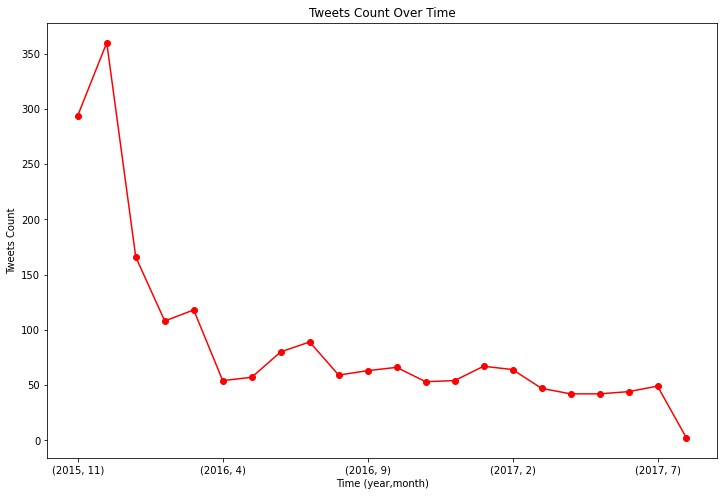

In [49]:
df_t = df.copy()
df_t.index = df_t['timestamp']
df_t.sort_index(inplace=True)
data_to_plot = df_t.groupby([(df_t.index.year),(df_t.index.month)]).tweet_id.count()
data_to_plot.plot(style='-ro', figsize=(12,8));
plt.title('Tweets Count Over Time');
plt.xlabel('Time (year,month)');
plt.ylabel('Tweets Count');

#### Tweets Interactions Over Time

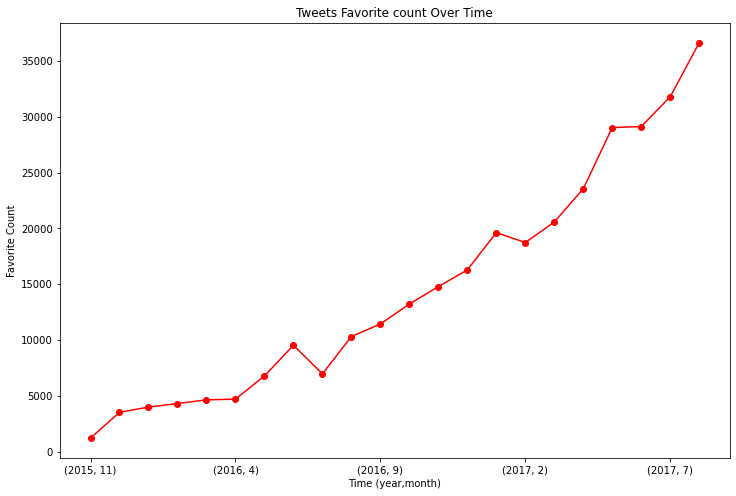

In [50]:
data_to_plot = df_t.groupby([(df_t.index.year),(df_t.index.month)]).favorite_count.mean()
data_to_plot.plot(style='-ro', figsize=(12,8));
plt.title('Tweets Favorite count Over Time');
plt.xlabel('Time (year,month)');
plt.ylabel('Favorite Count');

- Although the tweets count has decreased, the popularity has increased.

#### Most 10 popular breeds

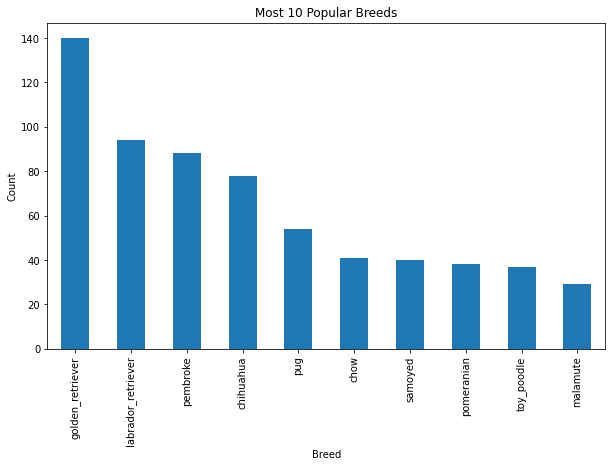

In [58]:
df['breed'] = df.p1
# df.info()
df.breed.groupby(df.breed).count().sort_values(ascending=False)[:10].plot(kind='bar',figsize=(10,6))
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Most 10 Popular Breeds')
plt.show()


#### Top 10 breeds with highest average number of retweets

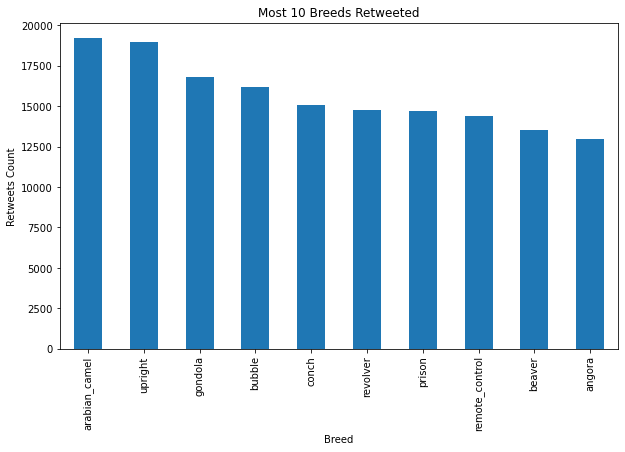

In [52]:
df.retweet_count.groupby(df.breed).mean().sort_values(ascending=False)[:10].plot(kind='bar',figsize=(10,6));
plt.title('Most 10 Breeds Retweeted')
plt.xlabel('Breed')
plt.ylabel('Retweets Count')
plt.show()

- Although it is not a dog, the Arabian Camel has the highest average retweet count
- This needs more investigation to detect whether the used prediction model is inacurate or not.

#### Count of tweets in each category (floofer, pupper,..)

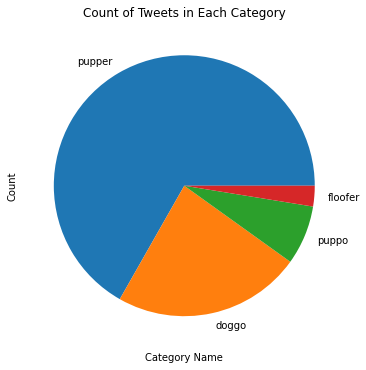

In [55]:
df.tweet_id.groupby(df.category).count().sort_values(ascending=False)[:10].plot(kind='pie',figsize=(10,6))
plt.xlabel('Category Name');
plt.ylabel('Count');
plt.title('Count of Tweets in Each Category');

- The majority of the tweeted are categorized as pupper 